# **Heart Disease Diagnostic Tool**

## **Introduction**

Cardiovascular diseases are the leading cause of death globally, estimated to take around 17.9 million lives each year. It is a group of disorders of the heart and blood vessels and include coronary heart disease, cerebrovascular disease, rheumatic heart disease and other conditions (WHO, n.d.). For our project, the question we are trying to answer is:

“Can we use patient attributes from a clinic's database to predict whether a patient has heart disease?”

The data set used to answer this questions was built using 303 patient information from Cleveland and was processed to include 14 out of 76 attributes most commonly used by published experiments. It was obtained from https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data (UCI Machine Learning Repository, n.d.).


### **Preliminary exploratory data analysis:**

In [1]:
library(rvest)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()         masks stats::filter()
✖ readr::guess_encoding() masks rvest::guess_encoding()
✖ dplyr::lag()            masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fi

#### **Reading and Wrangling the Data**

In [2]:
set.seed(293)

dataset_test <- download.file(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
    "heart_disease.csv")

heart_data <- read_csv("heart_disease.csv", col_names = FALSE)


heart_data <- rename(heart_data, 
                     age =X1, #represented in years - numerical
                     sex =X2, #1 representing male; 0 representing female - categorical
                     cp =X3, #Chest pain type - categorical 
                     trestbps =X4, #resting blood pressure (mmHg) - numerical
                     chol = X5, #serum cholesterol (mg/dl) - numerical
                     fbs =X6, #fasting blood sugar > 120 mg/dl (1 = true; 0 = false) - categorical
                     restecg=X7, #resulting electrocardiographic results - categorical
                     thalach=X8, #maximum heart rate achieved - numerical
                     exang=X9, #exercise induced angina - categorical
                     oldpeak=X10, #slope of peak exercise ST segment - categorical
                     slope=X11, #slope of peak exercise ST segment - categorical
                     ca=X12, #number of major vessels - categorical
                     thal=X13, #thalassemia Severity - categorical
                     diagnosis=X14) #diagnosis of heart disease - categorical

idx <- heart_data == "?"
is.na(heart_data) <- idx                                 #eliminates ? and replaces with NA

heart_data[] <- sapply(heart_data, as.numeric) #converts all the data to numeric

names = c('sex', 'cp', 'exang', 'slope', 'thal', 'diagnosis', "restecg", "ca", "fbs")
heart_data[,names] <- lapply(heart_data[,names] , factor)

heart_data <- mutate(heart_data, diagnosis = ifelse(diagnosis == "1"|diagnosis == "2"|diagnosis == "3"|diagnosis == "4", "Positive", "Negative"))
heart_data <- mutate(heart_data, diagnosis = as.factor(diagnosis))          #changes the diagnosis values to strings

heart_data


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,Negative
67,1,4,160,286,0,2,108,1,1.5,2,3,3,Positive
67,1,4,120,229,0,2,129,1,2.6,2,2,7,Positive
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1,7,Positive
57,0,2,130,236,0,2,174,0,0.0,2,1,3,Positive
38,1,3,138,175,0,0,173,0,0.0,1,NA,3,Negative


## **Methods**

#### **Splitting data into training and testing sets**

In [3]:
heart_split <- initial_split(heart_data, prop = 0.75, strata = diagnosis)          #splits data
heart_train <- training(heart_split)
heart_test <- testing(heart_split) 

We will be using K-nearest neighbours to solve our classification question, so we must split our data into a training set and a testing set. Training set will be used for building the classifier while the testing set will be used for evaluating accuracy of the classifier. 

Later on we will perform a 5-fold cross-validation to select the number of neighbours that gives the highest accuracy for our classifier.

#### **Number of Positive and Negative diagnoses**

In [4]:
count_train_summary <- group_by(heart_train, diagnosis) |>
    summarize(count=n())
count_train_summary

diagnosis,count
<fct>,<int>
Negative,123
Positive,104


From the training dataset we can see there's a good representation of patients with and without heart disease which is good, as later on we will know if our diagnosis tool is actually making accurate predictions instead of always predicting postive/negative.

#### **Number of missing values in each column**

In [5]:
heart_data |>
    select(age, trestbps, chol, thalach, oldpeak, diagnosis) |>
    summarise_all(funs(sum(is.na(.))))

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


age,trestbps,chol,thalach,oldpeak,diagnosis
<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0


We decided to avoid using categorical variables as our predictors because our goal is to perform classification using K-nearest neighbors, which would work better with numerical predictors.

All variables of interest have no missing values.

#### **Average of numerical columns**

In [6]:
stats_avg <- heart_train |>
    select(age, trestbps, chol, thalach, oldpeak, diagnosis) |>
    group_by(diagnosis) |>
    summarize(across(age:oldpeak, mean, na.rm = TRUE))

stats_avg

diagnosis,age,trestbps,chol,thalach,oldpeak
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Negative,51.82114,128.3008,237.8862,158.9675,0.5699187
Positive,56.58654,132.1442,250.1635,139.1250,1.5788462


We then created this table to compare the average values of numerical attributes for positive and negative diagnoses. We see that age, chol, thalach, and oldpeak have the most significant difference between positive and negative diagnoses so we will perform visualization to choose two variables out of them to use in our model.

#### **Visualizations of Predictor Variables**


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



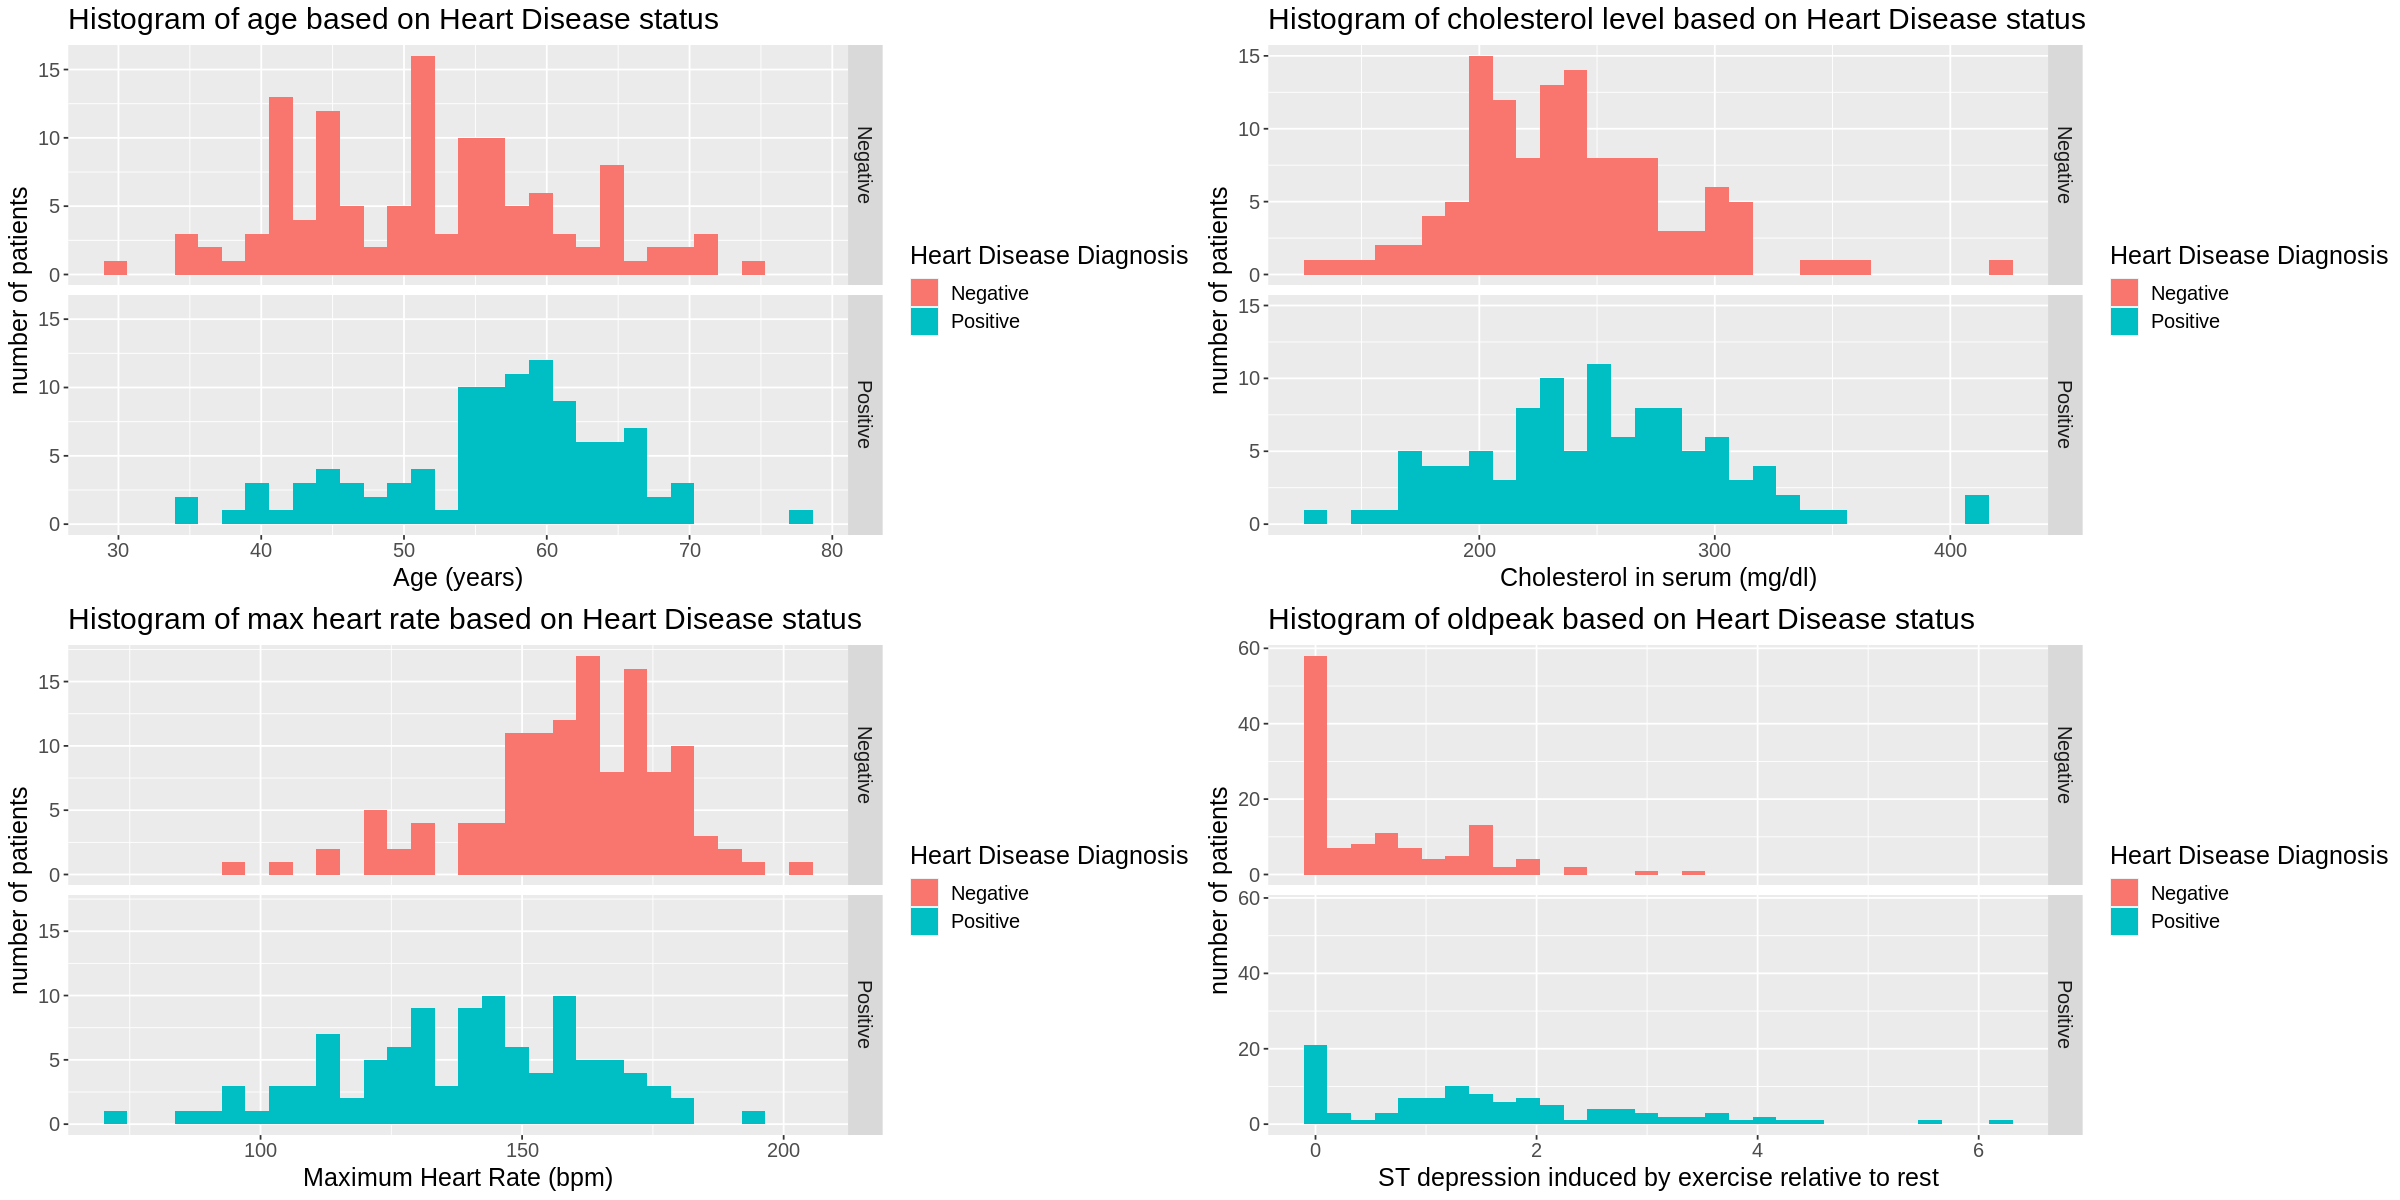

In [7]:
options(repr.plot.height = 10, repr.plot.width = 20)
library(gridExtra)

age_plot <- heart_train |>
        ggplot(aes(x = age, fill = diagnosis)) +
        geom_histogram() +
        labs(x = "Age (years)", y = "number of patients", fill = "Heart Disease Diagnosis") + 
        ggtitle("Histogram of age based on Heart Disease status") +
        theme(text = element_text(size = 15)) +
        facet_grid(rows = vars(diagnosis))

chol_plot <- heart_train |>
        ggplot(aes(x = chol, fill = diagnosis)) +
        geom_histogram() +
        labs(x = "Cholesterol in serum (mg/dl)", y = "number of patients", fill = "Heart Disease Diagnosis") + 
        ggtitle("Histogram of cholesterol level based on Heart Disease status") +
        theme(text = element_text(size = 15)) +
        facet_grid(rows = vars(diagnosis))


thalach_plot <- heart_train |>
        ggplot(aes(x = thalach, fill = diagnosis)) +
        geom_histogram() +
        labs(x = "Maximum Heart Rate (bpm)", y = "number of patients", fill = "Heart Disease Diagnosis") + 
        ggtitle("Histogram of max heart rate based on Heart Disease status") +
        theme(text = element_text(size = 15)) +
        facet_grid(rows = vars(diagnosis))


oldpeak_plot <- heart_train |>
        ggplot(aes(x = oldpeak, fill = diagnosis)) +
        geom_histogram() +
        labs(x = "ST depression induced by exercise relative to rest", y = "number of patients", fill = "Heart Disease Diagnosis") + 
        ggtitle("Histogram of oldpeak based on Heart Disease status") +
        theme(text = element_text(size = 15)) +
        facet_grid(rows = vars(diagnosis))


grid.arrange(age_plot, chol_plot, thalach_plot, oldpeak_plot, ncol = 2)

These histograms show the number of patients that have negative and positive diagnosis for the four variables we are exploring.

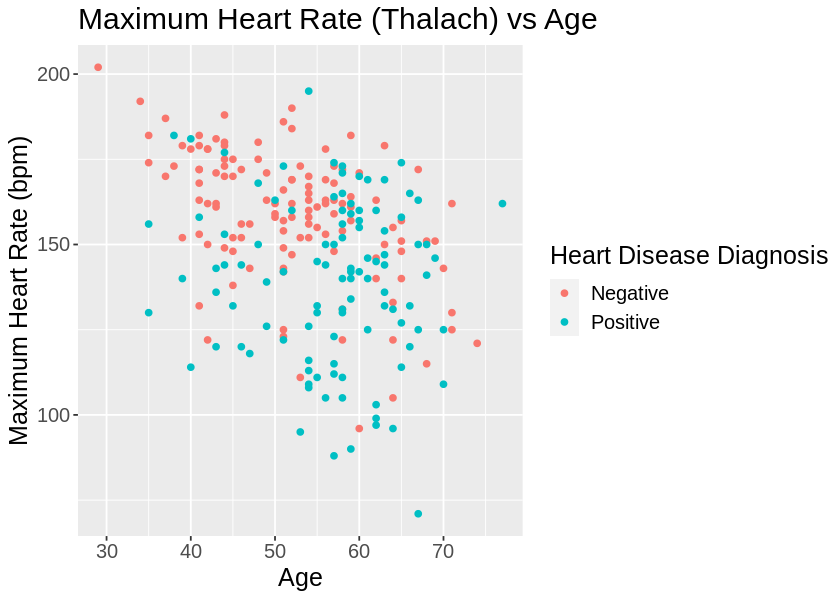

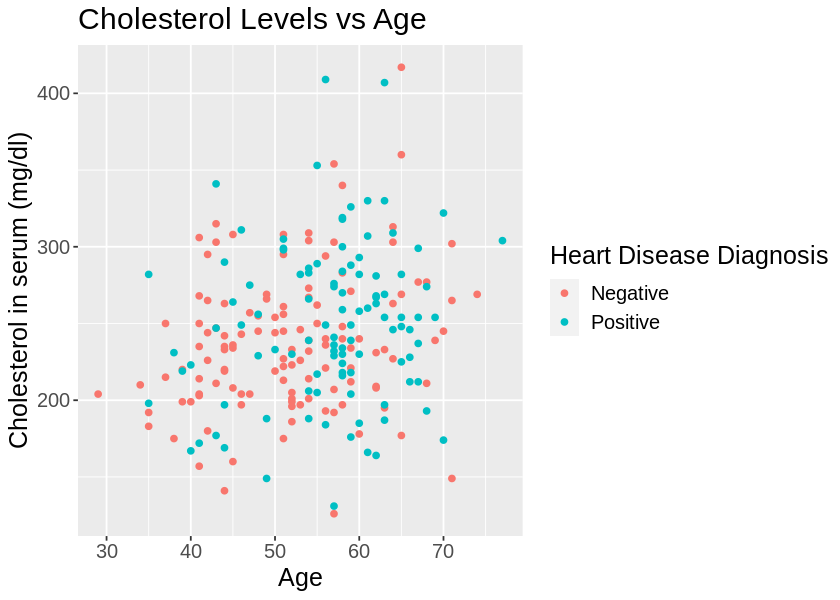

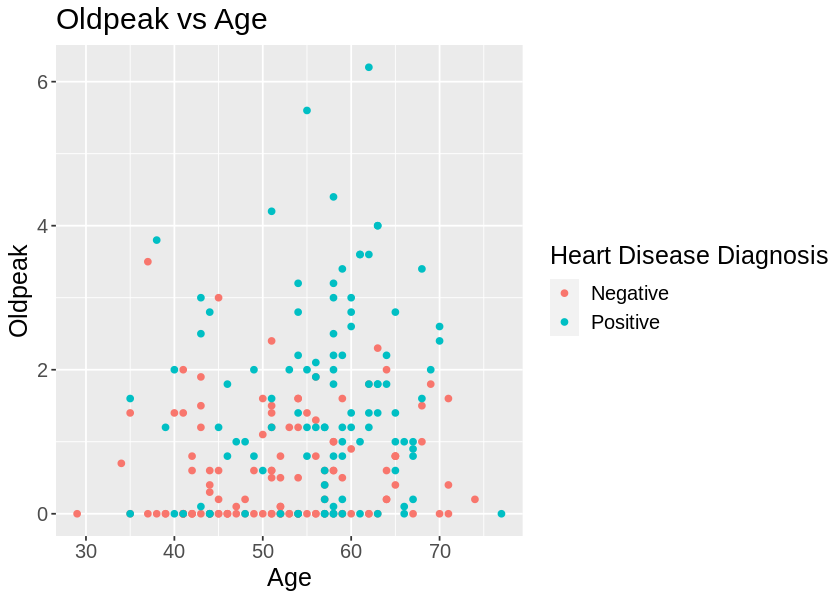

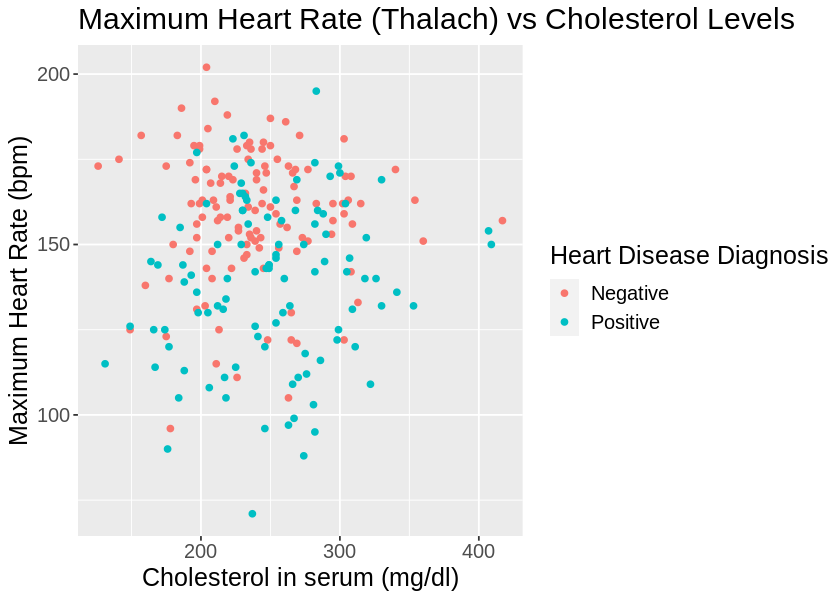

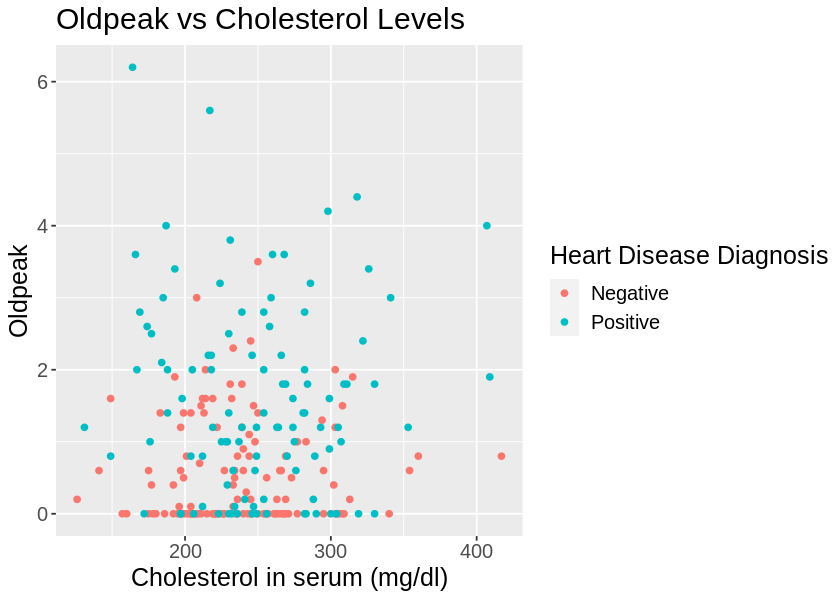

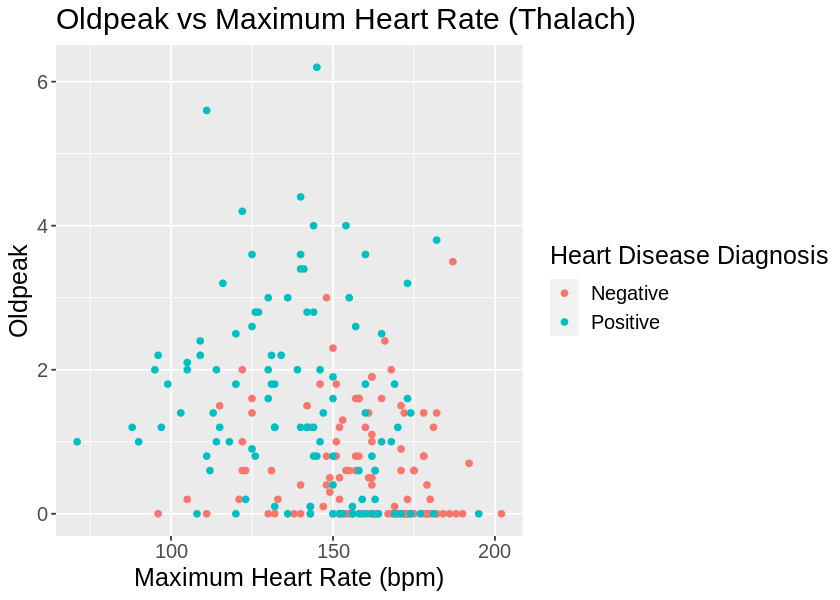

In [8]:
options(repr.plot.height = 5, repr.plot.width = 7)

age_thalach_plot <- heart_train |>
    ggplot(aes(x=age, y=thalach, color= diagnosis))+
    geom_point()+
    labs(x="Age", y="Maximum Heart Rate (bpm)", color="Heart Disease Diagnosis") +
    theme(text = element_text(size = 15)) +
    ggtitle("Maximum Heart Rate (Thalach) vs Age")
age_thalach_plot

age_chol_plot <- heart_train |>
    ggplot(aes(x=age, y=chol, color= diagnosis))+
    geom_point()+
    labs(x="Age", y="Cholesterol in serum (mg/dl)", color="Heart Disease Diagnosis") +
    theme(text = element_text(size = 15)) +
    ggtitle("Cholesterol Levels vs Age")
age_chol_plot

age_oldpeak_plot <- heart_train |>
    ggplot(aes(x=age, y=oldpeak, color= diagnosis))+
    geom_point()+
    labs(x="Age", y="Oldpeak", color="Heart Disease Diagnosis") +
    theme(text = element_text(size = 15)) +
    ggtitle("Oldpeak vs Age")
age_oldpeak_plot

chol_thalach_plot <- heart_train |>
    ggplot(aes(x=chol, y=thalach, color= diagnosis))+
    geom_point()+
    labs(x="Cholesterol in serum (mg/dl)", y="Maximum Heart Rate (bpm)", color="Heart Disease Diagnosis") +
    theme(text = element_text(size = 15)) +
    ggtitle("Maximum Heart Rate (Thalach) vs Cholesterol Levels")
chol_thalach_plot

chol_oldpeak_plot <- heart_train |>
    ggplot(aes(x=chol, y=oldpeak, color= diagnosis))+
    geom_point()+
    labs(x="Cholesterol in serum (mg/dl)", y="Oldpeak", color="Heart Disease Diagnosis") +
    theme(text = element_text(size = 15)) +
    ggtitle("Oldpeak vs Cholesterol Levels")
chol_oldpeak_plot

oldpeak_thalach_plot <- heart_train |>
    ggplot(aes(x=thalach, y=oldpeak, color= diagnosis))+
    geom_point()+
    labs(x="Maximum Heart Rate (bpm)", y="Oldpeak", color="Heart Disease Diagnosis") +
    theme(text = element_text(size = 15)) +
    ggtitle("Oldpeak vs Maximum Heart Rate (Thalach)")
oldpeak_thalach_plot


We plotted the four variables against each other to narrow our number of predictors. We see that oldpeak values for many observations was zero, causing lots of overlap, so we decided not to use it.

Looking at the three graphs plotting age, serum cholesterol and thalach against each other, we decided that `age` and `thalach` are the best variables to use in our model because the graph for thalach versus age shows regions of positive and negative heart disease diagnoses which is useful for K-nearest neighbour classification. For the other two graphs, the pattern for positive and negative heart diagnoses isn't as clear and data points for positive and negative diagnoses are interspersed in one another. 

We can visualize the results of predicted diagnoses by creating a bar graph from a confusion matrix, which would compare the number of accurate predictions with inaccurate predictions. 

### **Data Analysis**

From our intial analysis, we decide to use age and thalach as the two predicting variables to determine risk of heart disease. To accomplish our goal, we firstly perform a cross-validation using the vfold_cv function set to v = 5 for a 5-fold cross-validation. We can then create a K-nearest neighbor model specification setting tune for neighbors argument followed by a workflow analysis computing accuracies for k values from 1 to 25. We can then filter these results for the accuracy, graph a line plot with neighbours on the x-axis and the mean on the y-axis, and extract the k value that corresponds to the highest accuracy.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5600220,5,0.02526279,Preprocessor1_Model01
2,accuracy,binary,0.5600220,5,0.02526279,Preprocessor1_Model02
3,accuracy,binary,0.6351076,5,0.03509645,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
23,accuracy,binary,0.6932148,5,0.05113912,Preprocessor1_Model23
24,accuracy,binary,0.6932148,5,0.05113912,Preprocessor1_Model24
25,accuracy,binary,0.7020070,5,0.04900481,Preprocessor1_Model25


[1] 19

# A tibble: 1 × 7
  neighbors .metric  .estimator  mean     n std_err .config              
      <dbl> <chr>    <chr>      <dbl> <int>   <dbl> <chr>                
1        19 accuracy binary     0.711     5  0.0492 Preprocessor1_Model19


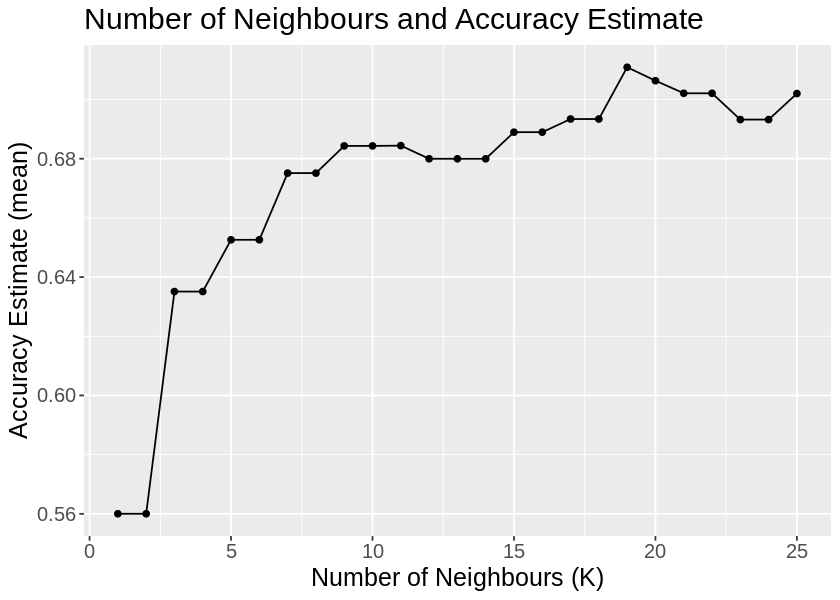

In [23]:
set.seed(293)
heart_recipe <-recipe(diagnosis ~ age + thalach, data = heart_train) |>   #creates a recipe containing oldpeak+thalach
    step_scale(all_predictors()) |>                                       #as our predictors, as well as scaling them.                         
    step_center(all_predictors())

## Cross Validation 
# using 5 folds
heart_vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 25,by= 1))

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
    tune_grid(resamples= heart_vfold, grid= k_vals) |>
    collect_metrics()

#compute accuracy for every fold
accuracies <- knn_results |>
  filter(.metric == "accuracy")
accuracies

#get row (and K value) that corresponds to the highest accuracy
best_k <- accuracies |>
    filter(mean == max(mean)) |>                #neighbours = 19
    select(neighbors) |>
    pull()
best_k


#plot of Accuracy vs K
accuracy_plot <- accuracies |>
    ggplot(aes(x= neighbors, y=mean))+
    geom_point()+
    geom_line() +
    labs(x = "Number of Neighbours (K)", y="Accuracy Estimate (mean)") + 
    ggtitle("Number of Neighbours and Accuracy Estimate") +
    theme(text = element_text(size = 15))
accuracy_plot

print(filter(accuracies, neighbors == 19))               #prints the accuracy of a model with k = 19

We can see from the graph that the highest accuracy from our cross-validation tests corresponds to a k value of 19 neighbours, with an accuracy of ~71.1%. Therefore we will now create a K-nearest neighbour model using the number of neighbours set to 19, and test this model against our test data to evaluate performance.

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6710526


          Truth
Prediction Negative Positive
  Negative       25        9
  Positive       16       26

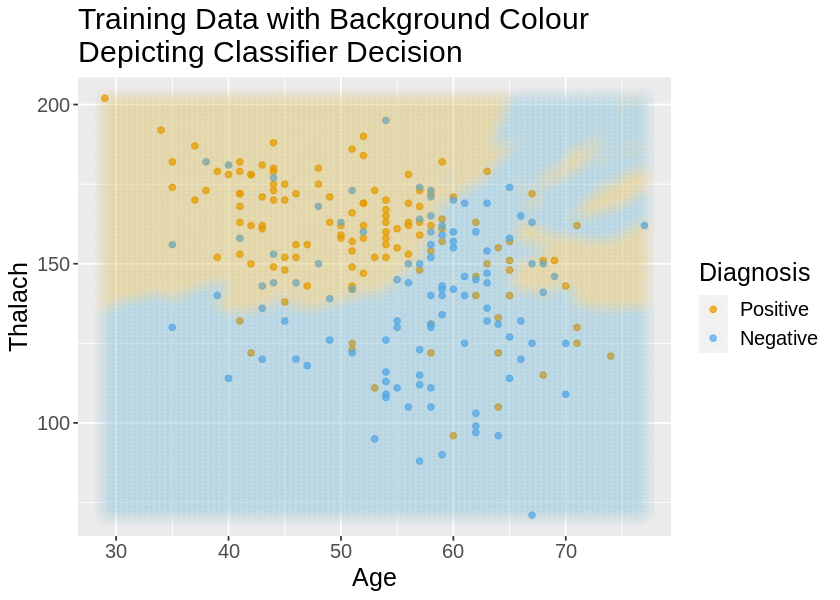

In [17]:
set.seed(293)

## KNN model creation using our optimal K value calculated from above

knn_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec2) |>
    fit(data = heart_train)

## test our model with the test data
heart_test_predictions <- predict(heart_fit, heart_test) |>
    bind_cols(heart_test)

# heart_test_predictions

## evaluate accurcay of our model using test data.
heart_prediction_accuracy <- heart_test_predictions |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy")

heart_prediction_accuracy


heart_mat <- heart_test_predictions |>
    conf_mat(truth = diagnosis, estimate = .pred_class)


heart_mat

are_grid <- seq(min(heart_data$age), 
                max(heart_data$age), 
                length.out = 100)
smo_grid <- seq(min(heart_data$thalach), 
                max(heart_data$thalach), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(age = are_grid, 
                                thalach = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(heart_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(diagnosis = .pred_class)


## Creates a heat map of regions depicting a visual representation of how our classifier algorothim picks diagnosis.
wkflw_plot <- heart_train |>
  ggplot() +
  geom_point(mapping = aes(x = age, 
                           y = thalach, 
                           color = diagnosis), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = age, 
                           y = thalach, 
                           color = diagnosis), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Diagnosis", 
       x = "Age", 
       y = "Thalach") +
  scale_color_manual(labels = c("Positive", "Negative"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 15)) +
    ggtitle("Training Data with Background Colour\nDepicting Classifier Decision")

wkflw_plot

## **Discussion**

We found that our classifier has a maximum of 71.1% accuracy after performing a 5 fold cross-validation and choosing the number of neighbours to be 19. When testing our classifier against our testing dataset, we got a 67.1% accuracy. Looking at the confusion matrix, we have 25 diagnoses that were negative which we predicted accurately and 26 diagnoses that were positive which we predicted accurately. However, 9 positive diagnoses were predicted to be negative and 16 negative diagnoses were predicted to be positive. Since predicting a negative diagnosis to be positive is less severe than predicting a positive diagnosis to be negative, we have 9 out of 76 cases (11.8%) that would result in severe consequences. We also created a scatter plot of thalach versus age where the background colour indicates the decision of the classifier.

We intially set out to determine if we could create a classificiation algorithim based on K-nearest neighbours using attributes from the cleveland heart disease data set. We managed to create an algoritim using `age` and `thalach` that resulted in a 67.1% accuracy agaisnt new data, which is slightly better than making random diagnosis aligning with our expectations based off the histogram and scatter plot analysis. However, due to the importance of making an accurate diagnosis this low accuracy level is not suitable for our purposes in predicting heart disease. 

~~We expected to find that the attributes, age and thalach, are able to accurately predict heart disease under a K-nearest neighbour model and our classifier to have an accuracy of at least 90%. However, the accuracy of our classifier turned out to only be 67.1% which is significantly lower than what we expected and making it unsuitable for predicting heart disease in a new patient given only information about age and thalach.~~

Our findings show that using the two attributes, `thalach` (max heart rate) and `age`, alone is unlikely sufficient enough to produce an accurate K-nearest neighbour model. However, since our results show a strong correlation between maximum heart rate and age with increased risk of heart disease. Perhaps under a different prediction model and/or with more prediction factors, maximum heart rate and age can still be used as important attributes to look out for when assessing heart disease risk. Or doctors could look at maximum heart rate and age as stronger indicators/risk factors when assessing heart disease risk in patients.

The mortality rate of heart diseases can be reduced if the diseases can be accurately predicted at early stages and preventative measures are implemented right away (Devi et al., 2021). A future question our project leads to is if a different selection of attributes or a different prediction model be used to predict heart disease in patients. Since our project was based soley off the Cleveland dataset, future projects from datasets like the ones from Hungary and Switzerland can be used to test if other attributes are better indicators of heart disease or if the attributes we used (`thalach` and `age`) are less accurate in the different datasets.

## **References**

Devi, A. G., Borra, S. P. R., & Sagar, K. V. (2021). A Method of Cardiovascular Disease Prediction using Machine Learning. IJERT. Retrieved Arpil 9, 2023, from https://doi.org/10.17577/IJERTCONV9IS05050

Heart Disease Data Set. (n.d.). UCI Machine Learning Repository. Retrieved March 11, 2023 from https://archive.ics.uci.edu/ml/datasets/Heart+Disease

World Health Organization. (n.d.). Cardiovascular diseases. World Health Organization. Retrieved March 11, 2023, from https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1 